# Trajectory Run 05
- This run will do a larger number of particles (2000) in the nominal Mau13 field
    - Should take 2-3 hours
- Note: changed z-min from 4000 to 3250 to see if particles reflect from back by collimator.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
from mu2e import mu2e_ext_path
from mu2e.dataframeprod import DataFrameMaker
from mu2e.mu2eplots import mu2e_plot, mu2e_plot3d
from matplotlib import gridspec
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['axes.axisbelow'] = True
import math
import pandas as pd
from time import sleep
import plotly.io as pio
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
from skhep.visual import MplPlotter as splt
from copy import deepcopy
from lmfit import Model, Parameters, report_fit
from hallprobesim_redux import *
from tqdm import tnrange, tqdm_notebook
#import pandas as pd
import seaborn as sns
from datetime import datetime
import time

<IPython.core.display.Javascript object>

In [2]:
init_notebook_mode(True)

In [3]:
from subprocess import call
import json
import plotly.utils
from plotly.offline import iplot, plot
from sys import getsizeof
import pickle as pkl

In [4]:
from mu2e.tools.particletransport import ElectronSwimmer

In [5]:
from mu2e.tools.mapinterp import get_df_interp_func

In [6]:
df = DataFrameMaker(mu2e_ext_path+"datafiles/Mau13/Mu2e_DSMap_V13",input_type='pkl').data_frame

df.eval("Bx = Bx / 10000",inplace=True)
df.eval("By = By / 10000",inplace=True)
df.eval("Bz = Bz / 10000",inplace=True)

df.eval("X = X * 1000",inplace=True)
df.eval("Y = Y * 1000",inplace=True)
df.eval("Z = Z * 1000",inplace=True)

In [7]:
df_interp = get_df_interp_func(df)

## Gen Run 05

In [8]:
str(datetime.now())

'2020-04-21 17:32:39.169019'

In [9]:
# import data (first prepped in python 2)
df_gen = pd.read_pickle(mu2e_ext_path+'root/ce_OLD.pkl')
# select good events only
df_gen = df_gen[df_gen['de._status'] != -1000]

In [10]:
len(df_gen)

665029

In [11]:
N = 2000

df_gen = df_gen.sample(n=N).reset_index(drop=True)

df_gen['X0'] = df_gen['demcgen_x']
df_gen['Y0'] = df_gen['demcgen_y']
df_gen['Z0'] = df_gen['demcgen_z']+10200.

df_gen = df_gen[['X0','Y0','Z0']]

#Great, now let's generate random theta and phi (from standard spherical coordinates) to denote the direction of the momentum vector. The magnitude is always 105 MeV!

df_gen['Phi0'] = np.random.uniform(0,2*np.pi,N)

df_gen['CosTheta0'] = np.random.uniform(-1,1,N)
df_gen['Theta0'] = np.arccos(df_gen['CosTheta0'])

mom = 105.

df_gen['Px0'] = mom * np.sin(df_gen['Theta0'])*np.cos(df_gen['Phi0'])
df_gen['Py0'] = mom * np.sin(df_gen['Theta0'])*np.sin(df_gen['Phi0'])
df_gen['Pz0'] = mom * np.cos(df_gen['Theta0'])
df_gen['Pt0'] = mom * np.sin(df_gen['Theta0'])

#Let's check out our generated starting conditions!

In [15]:
df_gen.head()

,X0,Y0,Z0,Phi0,CosTheta0,Theta0,Px0,Py0,Pz0,Pt0
0,34.098145,-3.336852,5588.867676,1.196960,0.654151,0.857736,29.002650,73.933042,68.685891,79.418187
1,34.987793,-19.958918,5544.411621,5.796905,-0.124070,1.695187,92.110885,-48.691598,-13.027402,104.188708
2,23.140381,59.009075,5588.912598,5.803141,0.132406,1.438000,92.312349,-48.063978,13.902669,104.075529
3,54.094482,-38.738037,5988.900879,0.683163,-0.104125,1.675110,80.993228,65.920896,-10.933087,104.429247
4,4.244141,56.443783,5544.438477,0.542988,-0.482231,2.073996,78.754363,47.528092,-50.634284,91.984614


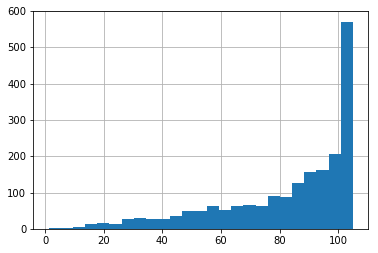

In [12]:
df_gen.Pt0.hist(bins=25)

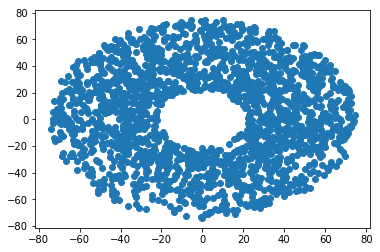

In [13]:
plt.scatter(x=df_gen.X0,y=df_gen.Y0)

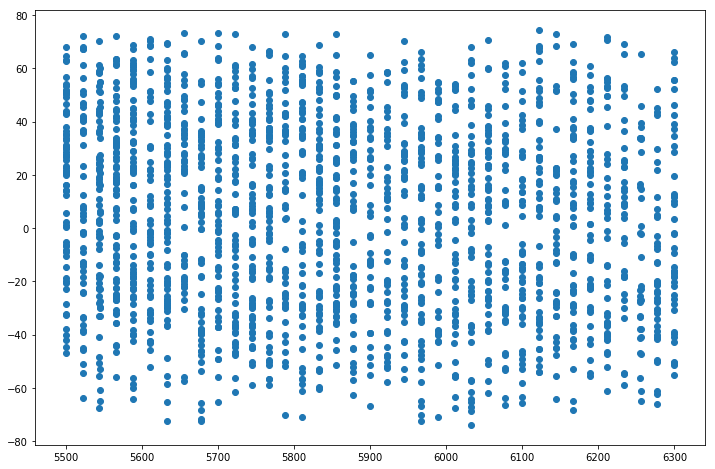

In [18]:
plt.scatter(x=df_gen.Z0,y=df_gen.Y0)

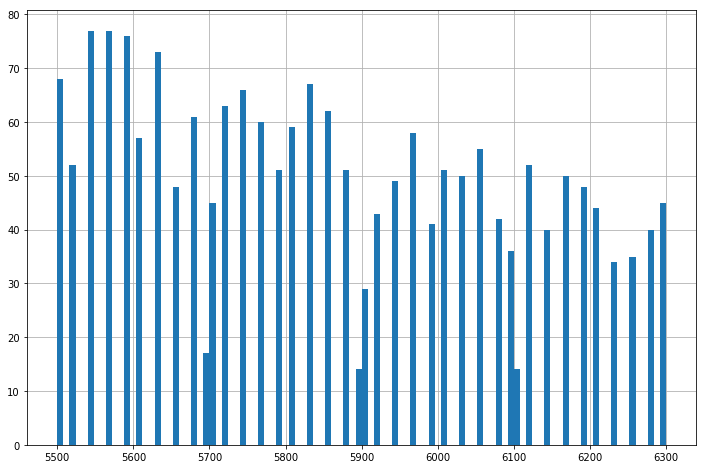

In [19]:
df_gen.Z0.hist(bins=100)

In [20]:
df_gen

,X0,Y0,Z0,Phi0,CosTheta0,Theta0,Px0,Py0,Pz0,Pt0
0,-28.129639,-42.771976,5988.847168,2.741250,-0.052452,1.623272,-96.564276,40.865736,-5.507462,104.855462
1,-36.264893,3.231885,5566.716797,5.192803,-0.546199,2.148617,40.647487,-77.997766,-57.350940,87.953793
2,31.549805,-53.007881,6166.625977,5.293762,0.352064,1.211021,53.971252,-82.131378,36.966751,98.277461
3,-9.619385,65.003555,5900.032227,3.467782,0.077552,1.493166,-99.163829,-33.544395,8.143005,104.683769
4,-53.383789,39.366871,5655.537598,2.555416,-0.841527,2.570900,-47.253405,31.377805,-88.360337,56.722579
5,67.361572,-32.133430,6055.564941,3.890815,0.941752,0.342993,-25.856331,-24.050142,98.883977,35.312309
6,40.506348,11.527344,5922.265625,5.464585,-0.541923,2.143520,60.292835,-64.435609,-56.901901,88.244964
7,-7.370850,-24.671757,5788.892090,1.019642,0.514468,1.030409,47.150528,76.705685,54.019123,90.038516
8,31.464600,-53.974609,6122.233398,3.043020,-0.204752,1.777007,-102.276542,10.114485,-21.498980,102.775454
9,-15.640381,47.039925,5522.222168,3.918822,0.736047,0.743584,-50.668389,-49.847305,77.284931,71.077700


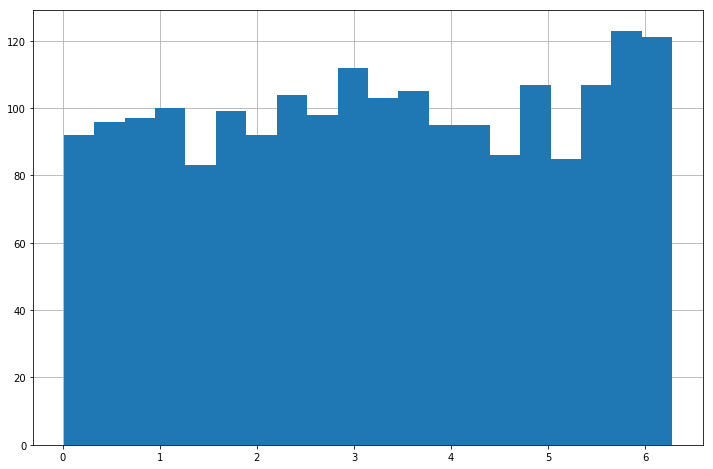

In [21]:
df_gen.Phi0.hist(bins=20)

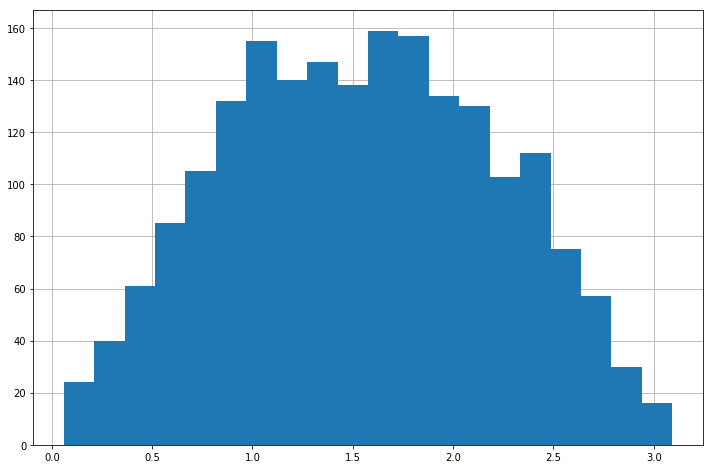

In [22]:
df_gen.Theta0.hist(bins=20)

Let's also dump the generating dataframe to pickle:

In [25]:
run_num = 'run05'
save_dir = f"/home/ckampa/Coding/Mu2E_Extras/trajectory/{run_num}/"
plot_dir = f"/home/ckampa/Coding/Mu2E_Extras/plots/trajectory/{run_num}/"
run_name = f"trajectory_{run_num}_"

In [26]:
pkl.dump(df_gen, open(save_dir+run_name+'INIT_COND.p','wb'))

Now we are ready to go!

In [27]:
#timesteps = np.linspace(0,4e-8,4000)
timesteps = np.linspace(0,8e-8,8000)

In [28]:
df_gen.head()

,X0,Y0,Z0,Phi0,CosTheta0,Theta0,Px0,Py0,Pz0,Pt0
0,-28.129639,-42.771976,5988.847168,2.741250,-0.052452,1.623272,-96.564276,40.865736,-5.507462,104.855462
1,-36.264893,3.231885,5566.716797,5.192803,-0.546199,2.148617,40.647487,-77.997766,-57.350940,87.953793
2,31.549805,-53.007881,6166.625977,5.293762,0.352064,1.211021,53.971252,-82.131378,36.966751,98.277461
3,-9.619385,65.003555,5900.032227,3.467782,0.077552,1.493166,-99.163829,-33.544395,8.143005,104.683769
4,-53.383789,39.366871,5655.537598,2.555416,-0.841527,2.570900,-47.253405,31.377805,-88.360337,56.722579


In [33]:
df_gen["Run"] = 5

In [36]:
1 // 100

0

In [51]:
df_gen["Subrun"] = pd.Series([i // 200 + 1 for i in range(len(df_gen))])
df_gen["Event"] = pd.Series([i % 200 for i in range(len(df_gen))])

In [52]:
df_gen

,X0,Y0,Z0,Phi0,CosTheta0,Theta0,Px0,Py0,Pz0,Pt0,Run,Subrun,Event
0,-28.129639,-42.771976,5988.847168,2.741250,-0.052452,1.623272,-96.564276,40.865736,-5.507462,104.855462,5,1,0
1,-36.264893,3.231885,5566.716797,5.192803,-0.546199,2.148617,40.647487,-77.997766,-57.350940,87.953793,5,1,1
2,31.549805,-53.007881,6166.625977,5.293762,0.352064,1.211021,53.971252,-82.131378,36.966751,98.277461,5,1,2
3,-9.619385,65.003555,5900.032227,3.467782,0.077552,1.493166,-99.163829,-33.544395,8.143005,104.683769,5,1,3
4,-53.383789,39.366871,5655.537598,2.555416,-0.841527,2.570900,-47.253405,31.377805,-88.360337,56.722579,5,1,4
5,67.361572,-32.133430,6055.564941,3.890815,0.941752,0.342993,-25.856331,-24.050142,98.883977,35.312309,5,1,5
6,40.506348,11.527344,5922.265625,5.464585,-0.541923,2.143520,60.292835,-64.435609,-56.901901,88.244964,5,1,6
7,-7.370850,-24.671757,5788.892090,1.019642,0.514468,1.030409,47.150528,76.705685,54.019123,90.038516,5,1,7
8,31.464600,-53.974609,6122.233398,3.043020,-0.204752,1.777007,-102.276542,10.114485,-21.498980,102.775454,5,1,8
9,-15.640381,47.039925,5522.222168,3.918822,0.736047,0.743584,-50.668389,-49.847305,77.284931,71.077700,5,1,9


## Multiprocessing Method (using joblib)

In [29]:
from joblib import Parallel, delayed
import multiprocessing

In [30]:
num_cores = multiprocessing.cpu_count()

In [31]:
num_cores

8

In [58]:
rtol = 1e-8
atol = 1e-8

def calc_track(row, i):
    mom = np.array([row.Px0,row.Py0,row.Pz0])
    pos = np.array([row.X0,row.Y0,row.Z0])
    #print(f"Start {i}: {mom}, {pos}")
    swimmer = ElectronSwimmer(mom,pos,df_interp,timesteps,'Dop853',rtol=rtol,atol=atol)
    X, t = swimmer.solve()
    df_out = pd.DataFrame(X,columns=['X','Y','Z','Vx','Vy','Vz'])
    df_out['time'] = t
    df_out['event'] = i
    df_out.event = df_out.event.astype('category')
    df_out['E0'] = swimmer.init_E
    df_out['EF'] = swimmer.final_E
    pkl.dump(df_out,open(save_dir+f"raw/subrun{row.Subrun:02d}/trj.raw.run_{row.Run:02d}.subrun_{row.Subrun:02d}.event_{row.Event:03d}.p",'wb'))
    #print(f"End {i}")

In [54]:
start = time.time()
Parallel(n_jobs=num_cores)(delayed(calc_track)(row,i) for i,row in tqdm_notebook(enumerate(
    df_gen.itertuples()), desc='particle #'))
stop = time.time()

In [55]:
stop - start

8770.854295253754

In [56]:
# seconds per event
(stop - start) / 2000

4.385427147626877

In [57]:
(stop - start) / 60

146.1809049208959